In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from create_grd_files import read_time_grid
import os
from typing import List, Tuple
from matplotlib.ticker import FormatStrFormatter

from itertools import chain

In [ ]:
plt.rcParams["figure.figsize"] = (20, 9)


In [ ]:
%%time
project_path = r'D:\remp_projects\mhd_krmkrm_full10'
data = read_time_grid(os.path.join(project_path, "project_krm", 'setka.txt'))
len(data)

In [ ]:
index_from = 1
index_to = len(data)
step = 1

slice_data = data[index_from:index_to:step]
len(slice_data)

In [ ]:

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


y = [item[0] for item in data]
cmap = get_cmap(max(y))


def scatter_plot(local_data, ax, x_lims, y_lims, y_log):
    _x_max = max([max(i[1]) for i in local_data])
    _x_min = min([min(i[1]) for i in local_data])
    _y_max = max([i[0] for i in local_data])
    _y_min = min([i[0] for i in local_data])

    if x_lims:
        ax.set_xlim([x_lims[0] if x_lims[0] else _x_min, x_lims[1] if x_lims[1] else _x_max * 1.05])
    else:
        ax.set_xlim([_x_min, _x_max * 1.05])

    if y_lims:
        ax.set_ylim([y_lims[0] if y_lims[0] else _y_min, y_lims[1] if y_lims[1] else _y_max * 1.05])
    else:
        ax.set_ylim([_y_min, _y_max * 1.05])

    for i, (time, arr) in enumerate(local_data):
        ax.scatter(arr, [time for _ in range(len(arr))])

    ax.grid(which='minor')
    if y_log:
        ax.set_yscale('log')

    ax.tick_params(axis='y', which='minor')

    ax.yaxis.set_minor_formatter(FormatStrFormatter("%.4e"))


def _plot(_data, x_lims=None, y_lims=None, y_log=True):
    fig, ax1 = plt.subplots(1)
    scatter_plot(_data, ax1, x_lims, y_lims, y_log)
    plt.show()



In [ ]:
_plot(slice_data, y_lims=[0, 1e-2])


In [ ]:
%%time

standard_deviation = 0.05
max_grid = max([len(arr) for time, arr in slice_data])
times = set()
times.add(slice_data[0][0])
times.add(slice_data[-1][0])

# for i in range(1, max_grid):
#     local_slice = [item for item in slice_data if len(item[1]) > i]
#     # local_slice = slice_data
local_slice = slice_data
value = sum(local_slice[0][1]) / len(local_slice[0][1])
value_diff = value * standard_deviation

for j in range(1, len(slice_data)):
    time, arr = slice_data[j]
    # arr = arr[:i + 1]
    avg = sum(arr) / len(arr)

    if abs(avg - value) > value_diff:
        times.add(time)

        value, value_diff = avg, avg * standard_deviation

print(len(times))
strict_data = [item for item in slice_data if item[0] in times]

In [ ]:

_plot(strict_data)


In [ ]:
fig, ax = plt.subplots(1)
ax.ticklabel_format(style='sci', scilimits=(0, 0), axis='x', useMathText=True)
ax.xaxis.major.formatter._useMathText = True

ax.hist([time for time in times if 1e-6 < time < 1e-4], bins=20)
ax.grid(which='both')

plt.show()

In [ ]:
_min, _max = 1e-6, 1e-5
len([time for time, arr in slice_data if _min < time < _max])

In [ ]:
def get_grids_from_batch(batch:List) -> np.ndarray:
    return np.array([item[1] for item in batch])

def merge_grid(grid_list: np.ndarray, relative_barrier: float) -> List:

    raw_data = np.unique(np.concatenate(grid_list))
    raw_data.sort()

    output = [raw_data[0], raw_data[1]]
    last_distance = raw_data[1] - raw_data[0]
    prev = raw_data[1]

    for i in range(2, len(raw_data) - 1):

        current_distance = raw_data[i] - prev

        if current_distance > last_distance * relative_barrier:
            output.append(raw_data[i])
            prev = raw_data[i]

    output.append(raw_data[-1])

    return output


In [ ]:
def recursive_merge(l: int, r: int, diff:float, data: List, results: List):

    if l == r:
        results.append(data[r])
        # raise Exception("Too small max grid count")
        return

    tmp_merge = merge_grid(get_grids_from_batch(data[l:r]), diff)

    if len(tmp_merge) < max_grid_count:
        time = data[r][0]
        results.append([time, tmp_merge])
        return

    else:
        m = (l + r) // 2
        recursive_merge(l, m - 1, diff, data, results)
        recursive_merge(m, r, diff, data, results)


In [ ]:
%%time
print(len(slice_data))
start_batch, filtered_batch = [], []
max_grid_count = 0

for time, arr in slice_data:
    max_grid_count = max(max_grid_count, len(arr))
    if time > 1e-6:
        filtered_batch.append([time, np.array(arr)])
    else:
        start_batch.append([time, np.array(arr)])
max_grid_count

In [ ]:
%%time

merged = [[1e-6, merge_grid(get_grids_from_batch(start_batch), 0.05)]]
max_grid_count = max_grid_count * 2

print(f'max_grid_count = {max_grid_count}')
diff = 0.1
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')

In [ ]:
_plot(merged, x_lims=[0, 20000])

In [ ]:
a = merge_grid(get_grids_from_batch(merged), 0.05)

print(len(a))
plt.scatter(a, [0 for _ in range(len(a))])

In [ ]:
def recursive_merge(l: int, r: int, diff:float, data: List, results: List):

    if l == r:
        results.append(data[r])
        # raise Exception("Too small max grid count")
        return

    tmp_merge = merge_grid(get_grids_from_batch(data[l:r]), diff)

    if len(tmp_merge) < max_grid_count:
        time = data[r][0]
        results.append([time, tmp_merge])
        return

    else:
        m = (l + r) // 2
        recursive_merge(l, m - 1, diff, data, results)
        recursive_merge(m, r, diff, data, results)


In [ ]:
%%time
print(len(slice_data))
start_batch, filtered_batch = [], []
max_grid_count = 0

for time, arr in slice_data:
    max_grid_count = max(max_grid_count, len(arr))
    if time > 1e-6:
        filtered_batch.append([time, np.array(arr)])
    else:
        start_batch.append([time, np.array(arr)])
max_grid_count

In [ ]:
%%time

merged = [[1e-6, merge_grid(get_grids_from_batch(start_batch), 0.05)]]
max_grid_count = max_grid_count * 2

print(f'max_grid_count = {max_grid_count}')
diff = 0.1
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')

In [ ]:
_plot(merged)

In [ ]:
a = merge_grid(get_grids_from_batch(merged), 0.05)

print(len(a))
plt.scatter(a, [0 for _ in range(len(a))])

In [ ]:
%%time

def recursive_merge(l: int, r: int, diff:float, data: List, results: List):

    if l == r:
        results.append(data[r])
        # raise Exception("Too small max grid count")
        return

    tmp_merge = merge_grid(data[l:r], diff)

    if len(tmp_merge) < max_grid_count:
        time = data[r][0]
        results.append([time, tmp_merge])
        return

    else:
        m = (l + r) // 2
        recursive_merge(l, m - 1, diff, data, results)
        recursive_merge(m, r, diff, data, results)


start_batch = [item for item in slice_data if 0 < item[0] < 1e-6]
filtered_batch = [item for item in slice_data if item[0] > 1e-6]

merged = [[1e-6, merge_grid(start_batch, 0.05)]]

max_grid_count = max([len(arr) for time, arr in filtered_batch]) * 2
print(f'max_grid_count = {max_grid_count}')
diff = 0.015
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')
_plot(merged, x_lims=[0, 60000], y_lims=[1e-2, None], y_log=True)

In [ ]:
%%time
print(len(slice_data))
start_batch, filtered_batch = [], []
max_grid_count = 0

for time, arr in slice_data:
    max_grid_count = max(max_grid_count, len(arr))
    if time > 1e-6:
        filtered_batch.append([time, np.array(arr)])
    else:
        start_batch.append([time, np.array(arr)])
max_grid_count

In [ ]:
%%time

merged = [[1e-6, merge_grid(get_grids_from_batch(start_batch), 0.05)]]
max_grid_count = max_grid_count * 2

print(f'max_grid_count = {max_grid_count}')
diff = 0.1
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')

In [ ]:
_plot(merged)

In [ ]:
a = merge_grid(get_grids_from_batch(merged), 0.05)

print(len(a))
plt.scatter(a, [0 for _ in range(len(a))])

In [ ]:
%%time

def recursive_merge(l: int, r: int, diff:float, data: List, results: List):

    if l == r:
        results.append(data[r])
        # raise Exception("Too small max grid count")
        return

    tmp_merge = merge_grid(data[l:r], diff)

    if len(tmp_merge) < max_grid_count:
        time = data[r][0]
        results.append([time, tmp_merge])
        return

    else:
        m = (l + r) // 2
        recursive_merge(l, m - 1, diff, data, results)
        recursive_merge(m, r, diff, data, results)


start_batch = [item for item in slice_data if 0 < item[0] < 1e-6]
filtered_batch = [item for item in slice_data if item[0] > 1e-6]

merged = [[1e-6, merge_grid(start_batch, 0.05)]]

max_grid_count = max([len(arr) for time, arr in filtered_batch]) * 2
print(f'max_grid_count = {max_grid_count}')
diff = 0.015
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')
_plot(merged, x_lims=[0, 60000], y_lims=[1e-2, None], y_log=True)

In [ ]:
%%time
print(len(slice_data))
start_batch, filtered_batch = [], []
max_grid_count = 0

for time, arr in slice_data:
    max_grid_count = max(max_grid_count, len(arr))
    if time > 1e-6:
        filtered_batch.append([time, np.array(arr)])
    else:
        start_batch.append([time, np.array(arr)])
max_grid_count

In [ ]:
%%time

merged = [[1e-6, merge_grid(get_grids_from_batch(start_batch), 0.05)]]
max_grid_count = max_grid_count * 2

print(f'max_grid_count = {max_grid_count}')
diff = 0.1
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')

In [ ]:
_plot(merged)

In [ ]:
a = merge_grid(get_grids_from_batch(merged), 0.05)

print(len(a))
plt.scatter(a, [0 for _ in range(len(a))])

In [ ]:
%%time

def recursive_merge(l: int, r: int, diff:float, data: List, results: List):

    if l == r:
        results.append(data[r])
        # raise Exception("Too small max grid count")
        return

    tmp_merge = merge_grid(data[l:r], diff)

    if len(tmp_merge) < max_grid_count:
        time = data[r][0]
        results.append([time, tmp_merge])
        return

    else:
        m = (l + r) // 2
        recursive_merge(l, m - 1, diff, data, results)
        recursive_merge(m, r, diff, data, results)


start_batch = [item for item in slice_data if 0 < item[0] < 1e-6]
filtered_batch = [item for item in slice_data if item[0] > 1e-6]

merged = [[1e-6, merge_grid(start_batch, 0.05)]]

max_grid_count = max([len(arr) for time, arr in filtered_batch]) * 2
print(f'max_grid_count = {max_grid_count}')
diff = 0.015
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')
_plot(merged, x_lims=[0, 60000], y_lims=[1e-2, None], y_log=True)

In [ ]:
a = merge_grid(merged, 0.05)

print(len(a))
plt.scatter(a, [0 for _ in range(len(a))])

In [161]:
%%time

merged = [[1e-6, merge_grid(get_grids_from_batch(start_batch), 0.05)]]
max_grid_count = max_grid_count * 2

print(f'max_grid_count = {max_grid_count}')
diff = 0.1
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')

C:\Users\niczz\AppData\Local\Temp\ipykernel_2056\2921566779.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([item[1] for item in batch])


max_grid_count = 92
170056 merged to 13
CPU times: total: 13.6 s
Wall time: 13.6 s


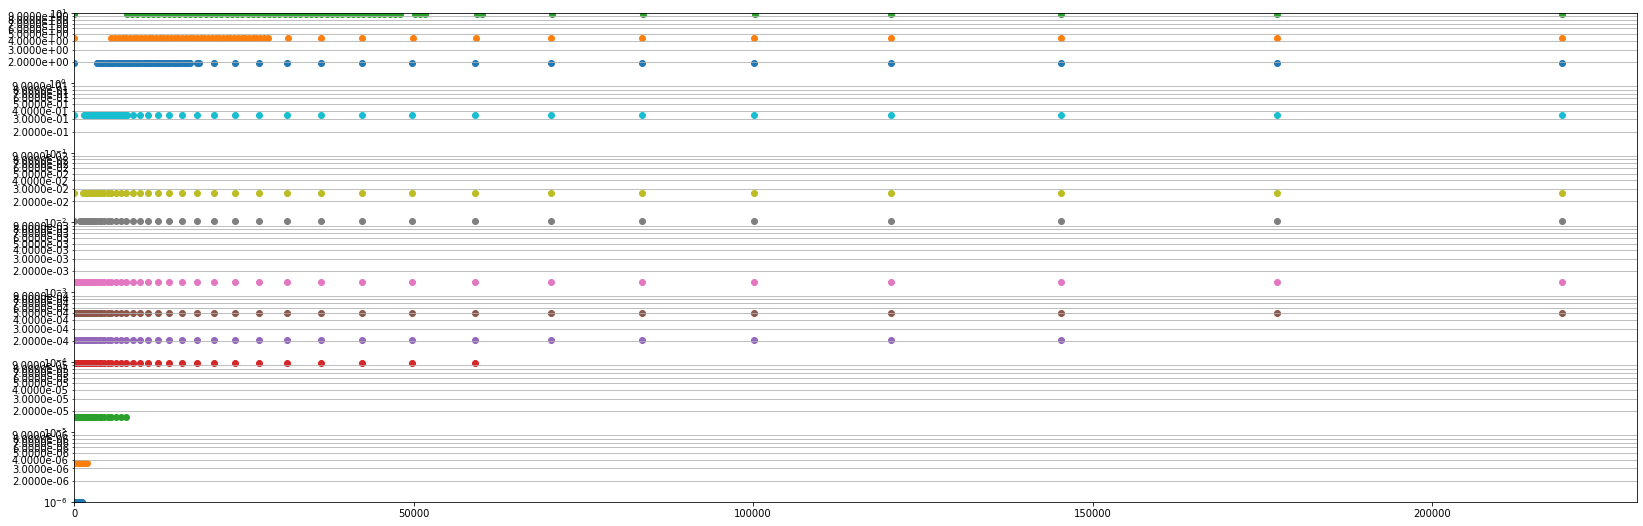

In [162]:
_plot(merged)

488


C:\Users\niczz\AppData\Local\Temp\ipykernel_2056\2921566779.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([item[1] for item in batch])


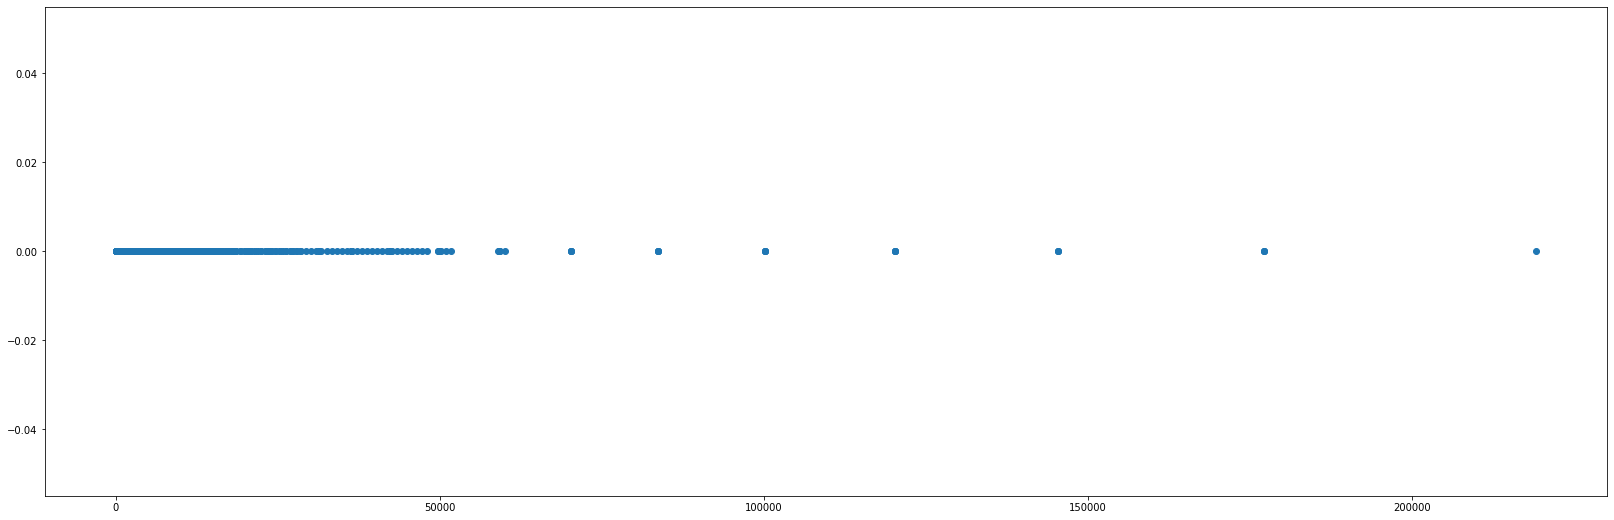

In [168]:
a = merge_grid(get_grids_from_batch(merged), 0.05)

print(len(a))
plt.scatter(a, [0 for _ in range(len(a))])

max_grid_count = 96
51516 merged to 33


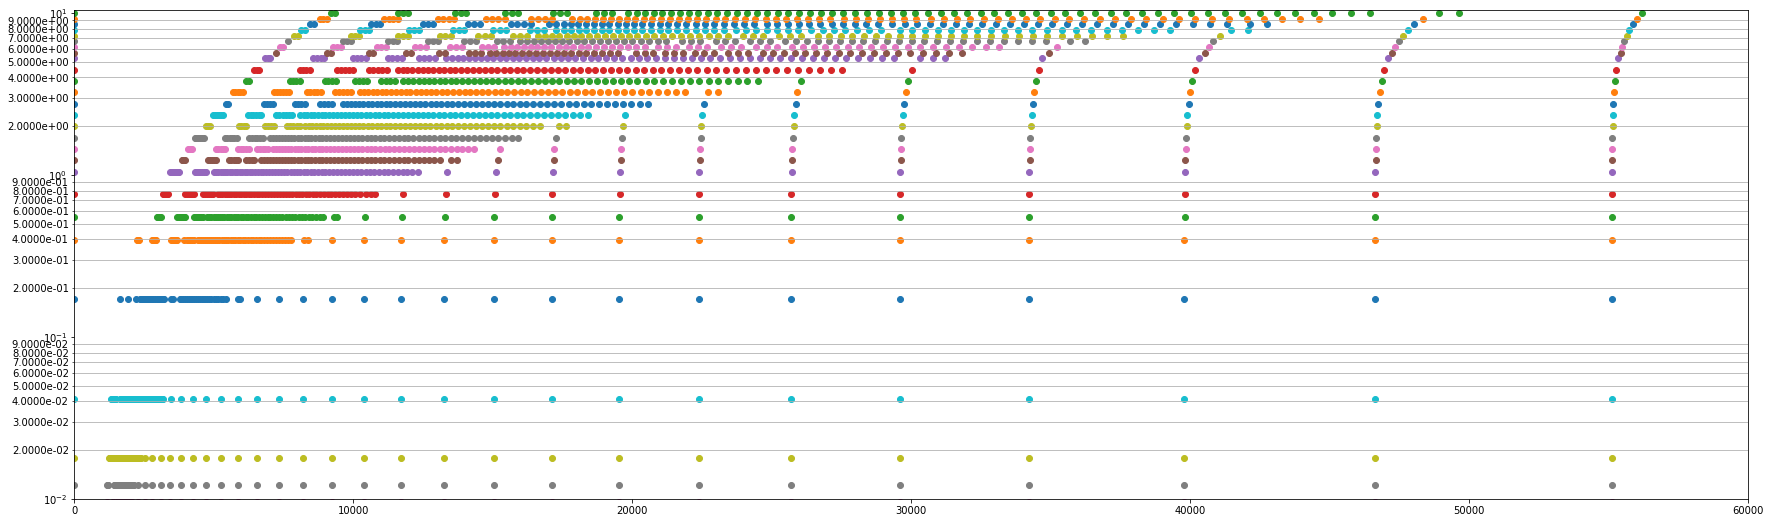

Wall time: 6.13 s


In [19]:
%%time

def recursive_merge(l: int, r: int, diff:float, data: List, results: List):

    if l == r:
        results.append(data[r])
        # raise Exception("Too small max grid count")
        return

    tmp_merge = merge_grid(data[l:r], diff)

    if len(tmp_merge) < max_grid_count:
        time = data[r][0]
        results.append([time, tmp_merge])
        return

    else:
        m = (l + r) // 2
        recursive_merge(l, m - 1, diff, data, results)
        recursive_merge(m, r, diff, data, results)


start_batch = [item for item in slice_data if 0 < item[0] < 1e-6]
filtered_batch = [item for item in slice_data if item[0] > 1e-6]

merged = [[1e-6, merge_grid(start_batch, 0.05)]]

max_grid_count = max([len(arr) for time, arr in filtered_batch]) * 2
print(f'max_grid_count = {max_grid_count}')
diff = 0.015
recursive_merge(0, len(filtered_batch) - 1, diff, filtered_batch, merged)

represent = [(time, len(gr)) for time, gr in merged]
print(f'{len(filtered_batch)} merged to {len(merged)}')
# print(*represent, sep='\n')
_plot(merged, x_lims=[0, 60000], y_lims=[1e-2, None], y_log=True)

173


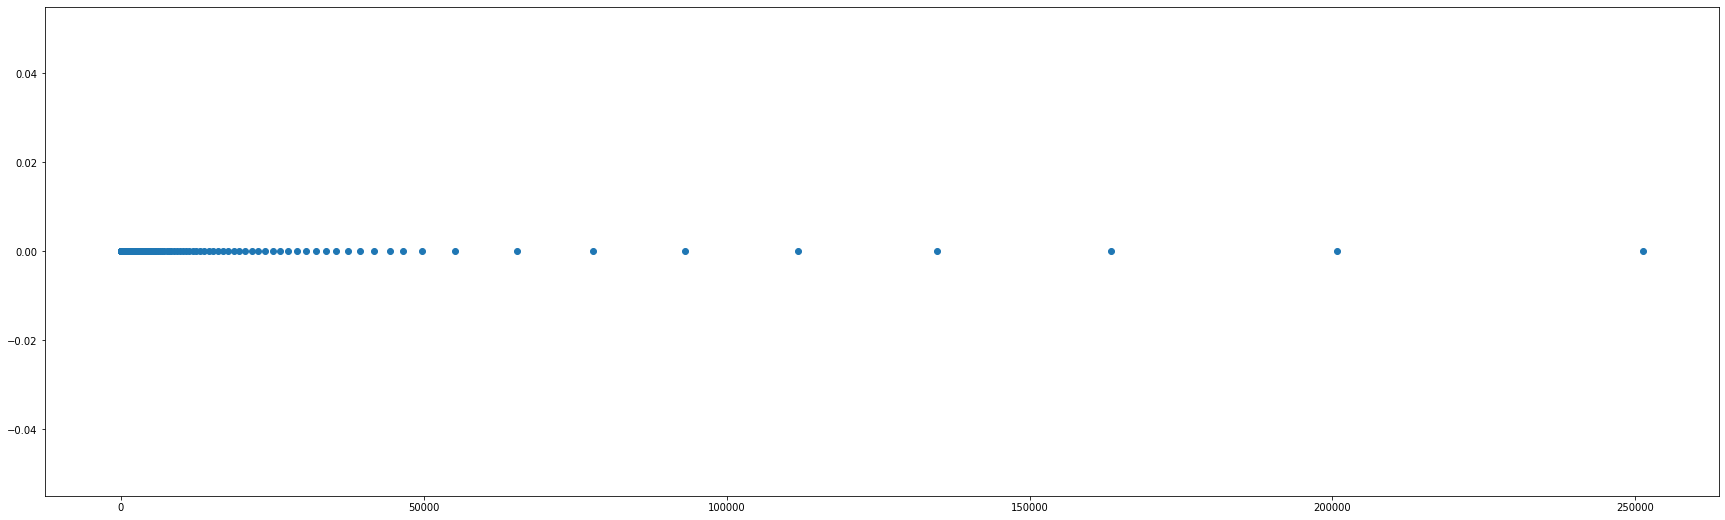

In [32]:
a = merge_grid(merged, 0.05)

print(len(a))
plt.scatter(a, [0 for _ in range(len(a))])